In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
basetable = pd.read_csv('../../Data/Gold/basetable.csv')


In [35]:
basetable.columns

Index(['datum', 'niveau', 'schepcorner_id', 'ploegnaam', 'ervaring_schepper',
       'ervaring_kopper', 'ervaring_duo', 'is_thuisploeg', 'kwart',
       'is_schepper_bank', 'is_kopper_bank', 'schepper_pos_rechts', 'positie',
       'kop_verplaatsen_achter', 'kop_veel_verplaatsen', 'kop_hor_verplaatsen',
       'goal', 'klassement_thuis', 'klassement_uit', 'uitslag_thuis',
       'uitslag_uit', 'score_voor_thuis', 'score_voor_uit',
       'ranking_klassement', 'klassement_veschil', 'score_verschil_voor',
       'schepcorner_nummer'],
      dtype='object')

In [36]:
cols_to_drop = ["datum", "schepcorner_id", "ploegnaam", "klassement_thuis","klassement_uit", 'uitslag_thuis',
       'uitslag_uit', 'score_voor_thuis', 'score_voor_uit'] 
basetable.drop(columns=cols_to_drop, inplace=True)

In [37]:
basetable.head()

,niveau,ervaring_schepper,ervaring_kopper,ervaring_duo,is_thuisploeg,kwart,is_schepper_bank,is_kopper_bank,schepper_pos_rechts,positie,kop_verplaatsen_achter,kop_veel_verplaatsen,kop_hor_verplaatsen,goal,ranking_klassement,klassement_veschil,score_verschil_voor,schepcorner_nummer
0,kern_laag,4.0,4.0,4.0,1,1,1,0,1,5,0,0,0,1,1.0,4.0,0,1
1,kern_laag,4.0,4.0,4.0,1,2,0,0,1,5,0,0,0,0,1.0,4.0,2,2
2,kern_laag,3.0,2.0,3.0,0,3,0,0,0,2,0,0,1,0,5.0,4.0,2,3
3,kern_laag,4.0,5.0,4.0,1,3,1,0,1,5,0,1,1,0,8.0,5.0,3,1
4,kern_laag,1.0,5.0,1.0,0,3,1,0,1,5,0,0,0,0,3.0,5.0,3,2


In [38]:
basetable.isnull().sum()

niveau                      0
ervaring_schepper           0
ervaring_kopper             0
ervaring_duo                0
is_thuisploeg               0
kwart                       0
is_schepper_bank            0
is_kopper_bank              0
schepper_pos_rechts         0
positie                     0
kop_verplaatsen_achter      0
kop_veel_verplaatsen        0
kop_hor_verplaatsen         0
goal                        0
ranking_klassement        253
klassement_veschil        253
score_verschil_voor         0
schepcorner_nummer          0
dtype: int64

In [39]:
### voorlopig
basetable["ranking_klassement"] = basetable["ranking_klassement"].fillna(7)
basetable["klassement_veschil"] = basetable["klassement_veschil"].fillna(6)


### Logistic Regression

In [40]:
# imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [41]:
# features en target splitsen
X = basetable.drop(columns=['goal'])
y = basetable['goal']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# scalen
categorical_features = ['niveau', 'positie']  
numeric_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)  # drop='first' om dummyval valkuil te vermijden
    ]
)

In [43]:
# Model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

In [44]:
#Hyperparameter tuning
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']  # Alleen deze ondersteunen L1
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ervaring_schepper',
                                                                          'ervaring_kopper',
                                                                          'ervaring_duo',
                                                                          'is_thuisploeg',
                                                                          'kwart',
                                                                          'is_schepper_bank',
                                                                          'is_kopper_bank',
                                                                          'schepper_pos_rechts',
                                                                          'kop_verplaatsen_achter',
                                                                          'kop_veel_verplaatsen',
                                                                          'kop_hor_verplaatsen',
                                                                          'ranking_klassement',
                                                                          'klassement_veschil',
                                                                          'score_verschil_voor',
                                                                          'schepcorner_nummer']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['niveau',
                                                                          'positie'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [45]:
best_logreg = grid_search.best_estimator_

y_pred = best_logreg.predict(X_test)

print("Beste hyperparameters:", grid_search.best_params_)
print("Test classificatierapport:\n", classification_report(y_test, y_pred))

Beste hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Test classificatierapport:
               precision    recall  f1-score   support

           0       0.88      0.70      0.78        40
           1       0.87      0.95      0.91        81

    accuracy                           0.87       121
   macro avg       0.87      0.83      0.84       121
weighted avg       0.87      0.87      0.86       121



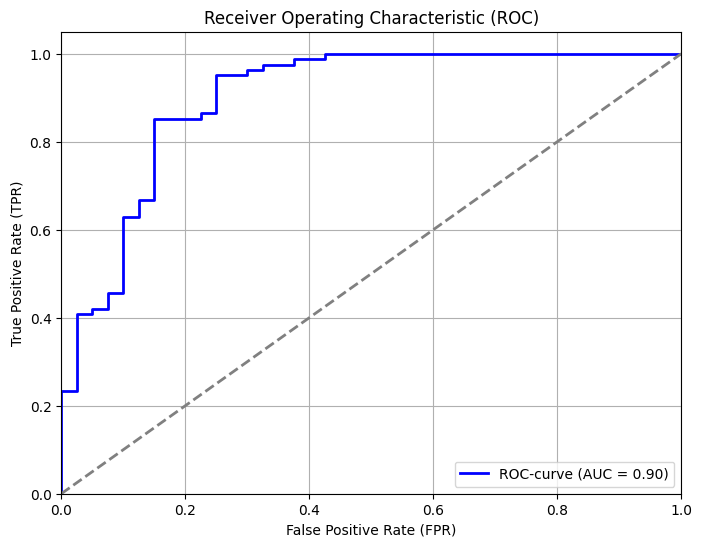

AUC-score: 0.901


In [46]:
# auc/roc curve
from sklearn.metrics import auc, roc_curve

y_test_probs = best_logreg.predict_proba(X_test)[:, 1]  # Kans op klasse '1' (goal)

# Bereken de ROC-curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)

# Bereken de AUC
roc_auc = auc(fpr, tpr)

# Plot de ROC-curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC-curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')  # Diagonaal = random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print de AUC
print(f"AUC-score: {roc_auc:.3f}")

In [47]:
# Haal de fitted preprocessor uit je pipeline
fitted_preprocessor = best_logreg.named_steps['preprocessor']

# Nu kan je veilig de feature names ophalen
feature_names = fitted_preprocessor.get_feature_names_out()

# Haal de coëfficiënten van je model
coefficients = best_logreg.named_steps['classifier'].coef_[0]

# Combineer in een dataframe
import pandas as pd
import numpy as np

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

# Sorteer op absolute waarde
feature_importances = feature_importances.sort_values(by='abs_coefficient', ascending=False)

print(feature_importances[['feature', 'coefficient']])


                        feature  coefficient
9     num__kop_veel_verplaatsen    -0.452246
10     num__kop_hor_verplaatsen    -0.450683
8   num__kop_verplaatsen_achter    -0.407416
15        cat__niveau_kern_laag     0.125916
2             num__ervaring_duo     0.120478
17               cat__positie_2     0.109242
20               cat__positie_5     0.096606
13     num__score_verschil_voor    -0.090904
1          num__ervaring_kopper     0.083991
3            num__is_thuisploeg    -0.081959
16        cat__niveau_nationaal     0.075358
0        num__ervaring_schepper     0.073006
5         num__is_schepper_bank    -0.063567
4                    num__kwart    -0.058222
19               cat__positie_4     0.033283
21               cat__positie_6     0.028246
6           num__is_kopper_bank     0.026701
11      num__ranking_klassement     0.024973
7      num__schepper_pos_rechts    -0.019940
14      num__schepcorner_nummer     0.012212
12      num__klassement_veschil    -0.006942
18        

### Random Forest

In [48]:
# import
from sklearn.ensemble import RandomForestClassifier

In [49]:
# Nieuwe pipeline (hergebruikt bestaande preprocessor)
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [50]:

# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
}

# GridSearchCV
grid_search_rf = GridSearchCV(
    rf_pipeline, 
    param_grid, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1,
    verbose=1
)


In [51]:

# Fitten
grid_search_rf.fit(X_train, y_train)

# Beste model
best_rf = grid_search_rf.best_estimator_


Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [52]:

# Evaluatie
y_pred_rf = best_rf.predict(X_test)
print("Beste hyperparameters:", grid_search_rf.best_params_)
print("\nTest classificatierapport:")
print(classification_report(y_test, y_pred_rf))



Beste hyperparameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

Test classificatierapport:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82        40
           1       0.89      0.96      0.92        81

    accuracy                           0.89       121
   macro avg       0.90      0.86      0.87       121
weighted avg       0.89      0.89      0.89       121



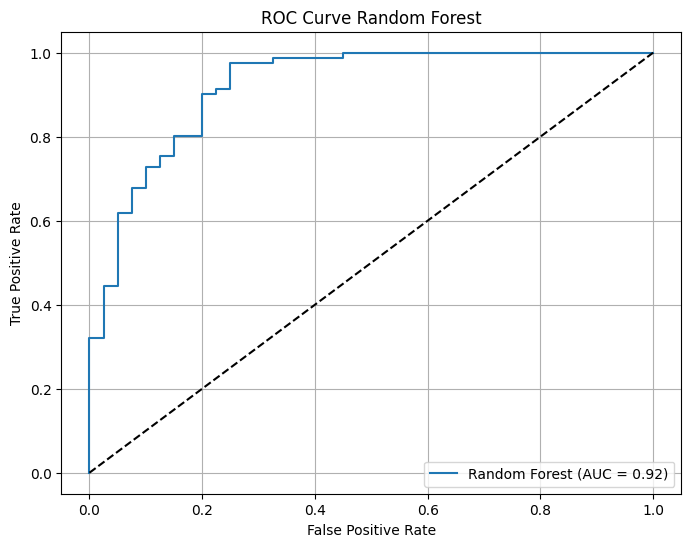

In [53]:
# ROC-curve
y_probs_rf = best_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Random Forest')
plt.legend()
plt.grid()
plt.show()

Random Forest Feature Importances:
                        feature  importance
9     num__kop_veel_verplaatsen    0.220784
10     num__kop_hor_verplaatsen    0.213794
8   num__kop_verplaatsen_achter    0.135148
13     num__score_verschil_voor    0.061211
11      num__ranking_klassement    0.053742
0        num__ervaring_schepper    0.045995
2             num__ervaring_duo    0.044539
1          num__ervaring_kopper    0.042071
12      num__klassement_veschil    0.036572
4                    num__kwart    0.029202


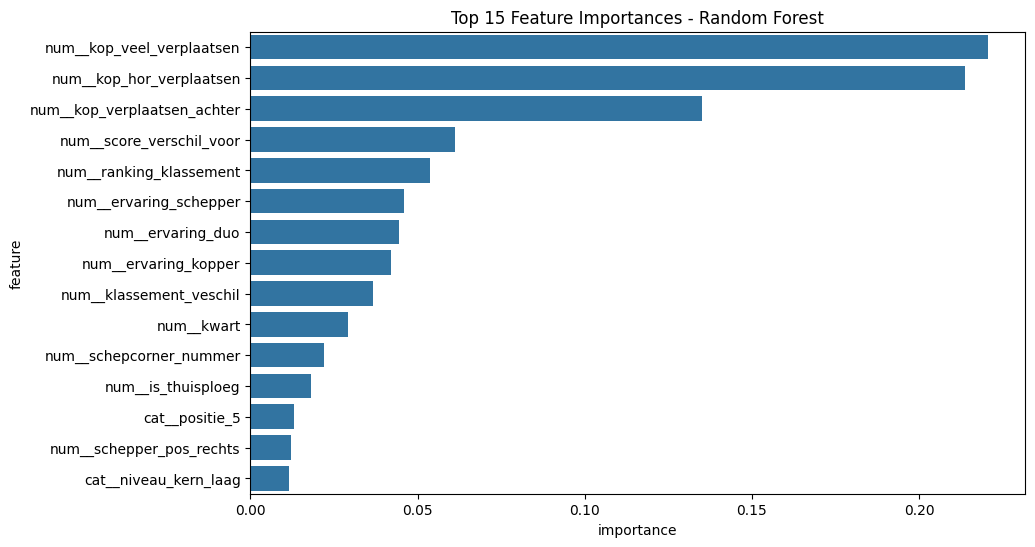

In [60]:
# Get feature importances from Random Forest
rf_importances = best_rf.named_steps['classifier'].feature_importances_

# Create a dataframe for easy visualization
rf_feat_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_importances
}).sort_values(by='importance', ascending=False)

# Show top features
print("Random Forest Feature Importances:")
print(rf_feat_importances.head(10))

# Optional: Plot the top 15 features
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(data=rf_feat_importances.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importances - Random Forest')
plt.show()


### XGboost

In [54]:
from xgboost import XGBClassifier


In [55]:

# New pipeline using the existing preprocessor
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Hyperparameter grid for tuning
param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# GridSearchCV
grid_search_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid_xgb,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)


In [56]:

# Train
grid_search_xgb.fit(X_train, y_train)

# Best model
best_xgb = grid_search_xgb.best_estimator_

# Evaluation
y_pred_xgb = best_xgb.predict(X_test)
print("Best hyperparameters:", grid_search_xgb.best_params_)
print("\nTest classification report:")
print(classification_report(y_test, y_pred_xgb))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best hyperparameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}

Test classification report:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82        40
           1       0.89      0.96      0.92        81

    accuracy                           0.89       121
   macro avg       0.90      0.86      0.87       121
weighted avg       0.89      0.89      0.89       121



c:\Users\cosyn\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:11:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


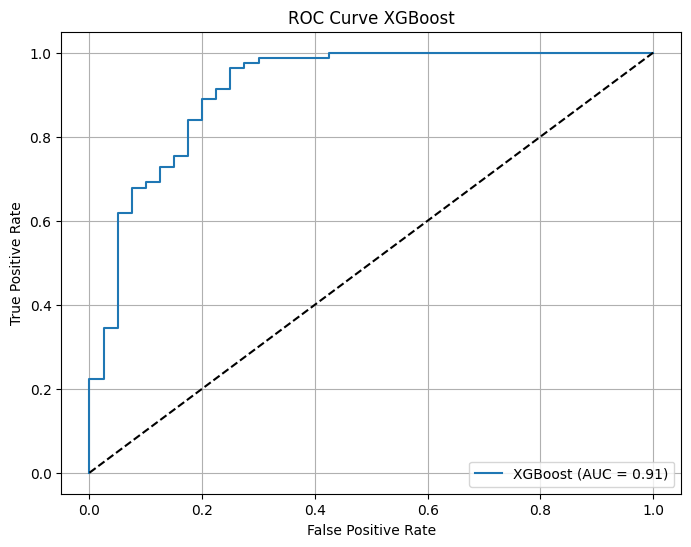

In [57]:

# ROC Curve
y_probs_xgb = best_xgb.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_probs_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve XGBoost')
plt.legend()
plt.grid()
plt.show()


XGBoost Feature Importances (via Booster):
   feature  importance
11     f11       347.0
13     f13       256.0
12     f12       237.0
2       f2       219.0
9       f9       173.0
1       f1       161.0
8       f8       160.0
0       f0       150.0
10     f10       147.0
4       f4       119.0


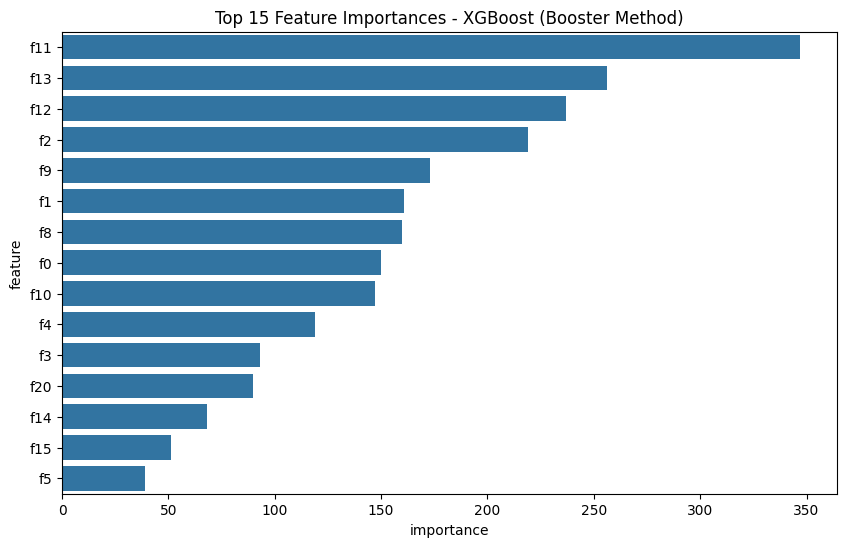

In [63]:
# Use Booster's get_score method to get feature importance (detailed)
xgb_booster = best_xgb.named_steps['classifier'].get_booster()

# Get feature importances by 'weight' or 'gain'
xgb_importances = xgb_booster.get_score(importance_type='weight')  # You can change to 'gain' or 'cover'

# Convert to DataFrame for better visualization
xgb_feat_importances = pd.DataFrame(list(xgb_importances.items()), columns=['feature', 'importance'])
xgb_feat_importances = xgb_feat_importances.sort_values(by='importance', ascending=False)


# Show top features
print("XGBoost Feature Importances (via Booster):")
print(xgb_feat_importances.head(10))

# Plot the top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_feat_importances.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importances - XGBoost (Booster Method)')
plt.show()

### AUC comparison

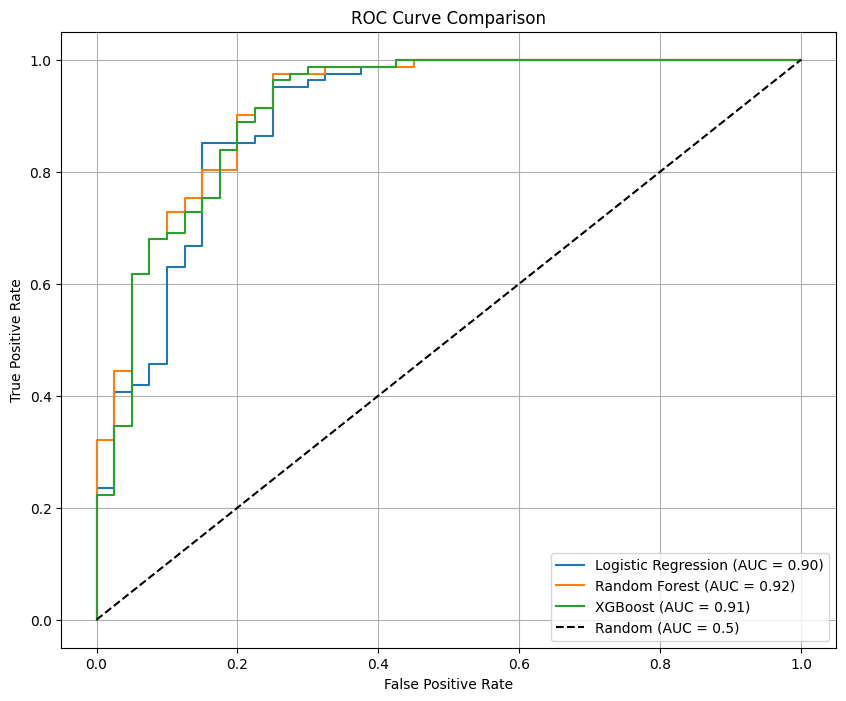

In [58]:
# Predict probabilities
y_probs_logreg = best_logreg.predict_proba(X_test)[:, 1]
y_probs_rf = best_rf.predict_proba(X_test)[:, 1]
y_probs_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Calculate ROC curve points
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_probs_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_probs_xgb)

# Calculate AUCs
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')

# Random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()